## Various neural network architectures from scratch
#### 1. Loading in data
#### 2. Declaring activation functions
#### 3. Creating loss functions
#### 4. Building core objects
#### 5. Applying to the XOR function
#### 6. Applying to the MNIST dataset without convolution
#### 7. Applying to the MNIST dataset with convolution


In [16]:
#We are only using torchvision for the mnist dataset
import torchvision.datasets as datasets
import numpy as np

n_epochs = 3

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

#convert to float numpy array
mnist_train_array = np.array(mnist_train.data).astype(np.float32)
mnist_train_labels = mnist_train.targets.numpy()

mnist_test_array = np.array(mnist_test.data).astype(np.float32)
mnist_test_labels = mnist_test.targets.numpy()

print("Loaded MNIST Dataset")
print("Train Data Shape: ", mnist_train_array.shape)

Loaded MNIST Dataset
Train Data Shape:  (60000, 28, 28)


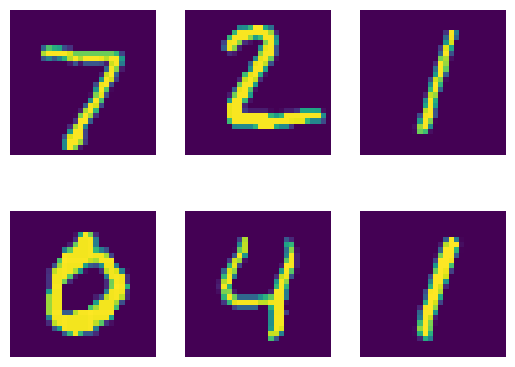

In [17]:
import matplotlib.pyplot as plt

def show_random_images(arr):
    fig, ax = plt.subplots(2,3)
    for i in range(6):
        ax[i//3, i%3].imshow(arr[i])
        ax[i//3, i%3].axis('off')
    plt.show()


show_random_images(mnist_test_array)

In [18]:
#Make sure the values of each element are between 0 and 1
mnist_train_array /= 255
mnist_test_array /= 255

In [19]:
#Abstract class for activation functions
class Activation:
    def __call__(self, *args, **kwargs):
        pass
    def gradient(self, *args, **kwargs):
        pass


ReLu Activation function is defined as
$$
f(x) = max(0, x)
$$

Its derivative (used for backprop) is defined as
$$
f'(x) = \begin{cases}
0 && if & x < 0 \\
1 && if & x \geq 0
\end{cases}
$$


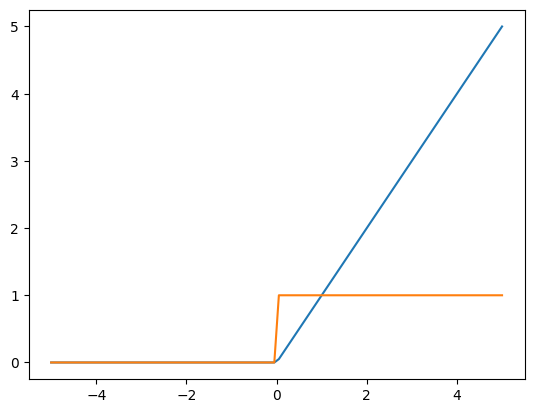

In [20]:
class ReLu(Activation):
    def __call__(self, x):
        return np.maximum(0, x)
    def gradient(self, x):
        return np.where(x >= 0, 1, 0)

#Plot the ReLu and ReLu' function
x = np.linspace(-5, 5, 100)
relu = ReLu()
plt.plot(x, relu(x))
plt.plot(x, relu.gradient(x))
plt.show()

Sigmoid Activation function is defined as
$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Its derivative is defined as
$$
f'(x) = f(x) * (1 - f(x))
$$

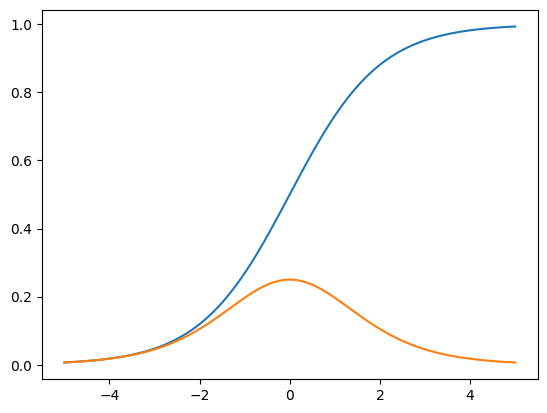

In [21]:
class Sigmoid(Activation):
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))
    def gradient(self, x):
        return np.exp(-x) / (1 + np.exp(-x))**2

#Plot the Sigmoid and Sigmoid' function
x = np.linspace(-5, 5, 100)
sigmoid = Sigmoid()
plt.plot(x, sigmoid(x))
plt.plot(x, sigmoid.gradient(x))
plt.show()

Softmax Activation function is defined as
$$
f(x) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$

I will be using it as the final activation function for the output layer of the network because the output is a probability distribution.

In [22]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        exp = np.exp(x - np.max(x))
        self.output = exp / np.sum(exp)
        return self.output

    def backward(self, out_err):
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(out_err, np.identity(self.input_size) - out)


Testing the LinearLayer class

We define Cross Entropy Loss as the loss function
Cross Entropy in multiclass classification is defined as:
$$
L_i = -\sum_{j=1}^{N} y_{ij} \log(p_{ij})
$$
where:
* $L_i$ is the loss value for the $i^{th}$ sample
* $N$ is the number of classes
* $y_{i,j}$ is the true value for the $j^{th}$ class for the $i^{th}$ sample
* $p_{i,j}$ is the predicted value for the $j^{th}$ class for the $i^{th}$ sample


Since we are using hot encoded labels such as for any sample $i$:
$$
y_{i,j} = \begin{cases}
1 && if & j = label_i \\
0 && if & j \neq label_i
\end{cases}
$$

The loss function simplifies to:
$$
L_i = -\log(p_{i, label_i})
$$


In [23]:
def cel_loss(pred, labels):
    pred_clip = np.clip(pred, 1e-7, 1 - 1e-7)
    #We use the hot encoded labels to calculate the loss
    #So we sum over the columns instead of looping to find the correct label
    return -np.sum(labels * np.log(pred_clip))

def cel_prime(pred, labels):
    #Cross Entropy Loss derivative assuming hot encoded labels and softmax activation
    return pred - labels


The mean squared error function is defined as:
$$
L_i = \frac{1}{N} \sum_{j=1}^{N} (y_{ij} - p_{ij})^2
$$
where:
* $L_i$ is the loss value for the $i^{th}$ sample
* $N$ is the number of classes
* $y_{i,j}$ is the true value for the $j^{th}$ class for the $i^{th}$ sample
* $p_{i,j}$ is the predicted value for the $j^{th}$ class for the $i^{th}$ sample
* $i$ is the sample index
* $j$ is the class index

Essentially, it is the distance between the predicted and true values squared.
The higher the distance the bigger the error value.

In [24]:
def mse(pred, labels):
    return np.mean(np.square(pred - labels))

def mse_prime(pred, labels):
    return 2*(pred-labels)/ pred.size

In [25]:
class LinearLayer:

    def __init__(self, input_size, output_size, learning_rate=0.01):

        #He initialization
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.learning_rate = learning_rate

    def forward(self, inputs):
        self.input = inputs
        return np.matmul(self.input, self.weights) + self.bias

    def backward(self, out_err):
        input_err = np.matmul(out_err, self.weights.T)
        weights_err = np.matmul(self.input.T, out_err)

        self.weights -= self.learning_rate * weights_err
        self.bias -= self.learning_rate * out_err

        return input_err

In [26]:
class ActivationLayer:

    def __init__(self, activation, learning_rate=0.01):
        self.activation = activation
        self.input = None
        self.learning_rate = 0.01

    def forward(self, inputs):
        self.input = inputs
        return self.activation(self.input)

    def backward(self, out_err):
        return out_err * self.activation.gradient(self.input)

In [27]:
inputs = np.random.randn(2)
layer = LinearLayer(2, 3)
print("Inputs: ", inputs)
print("Output: ", layer.forward(inputs))

Inputs:  [0.33399575 1.94901045]
Output:  [[-0.13632069  1.13131385 -0.34168955]]


In [32]:
class NeuralNetwork:
    def __init__(self, loss, loss_dx, learning_rate=0.01):
        self.layers = []
        self.loss = loss
        self.loss_dx = loss_dx
        self.learning_rate = learning_rate

        self.train_counter = []
        self.train_loss = []

    def add(self, layer):
        layer.learning_rate = self.learning_rate
        self.layers.append(layer)

    def forward(self, inputs):

        for layer in self.layers:
            inputs = layer.forward(inputs)

        return inputs

    def backward(self, out_err):

        #Backpropagate the error
        for layer in reversed(self.layers):
            out_err = layer.backward(out_err)

    def train(self, training_data, labels, epoch):
        running_loss = 0
        err = 0
        for i in range(len(training_data)):
            label = labels[i]
            data = training_data[i]

            #Forward pass
            output = self.forward(data)

            curr_loss = self.loss(output, label)
            running_loss += curr_loss
            err += curr_loss

            #Backward pass
            loss = self.loss_dx(output, label)
            self.backward(loss)

            if i % 1000 == 0:
                running_loss = 0.0
                self.train_loss.append(curr_loss)
                self.train_counter.append(i + epoch * len(training_data))

        # err /= len(training_data)
        # print("Epoch: ", epoch, " Loss: ", err)

    def predict(self, input_data):
        length = len(input_data)
        predictions = []

        for i in range(length):
            output = self.forward(input_data[i])
            predictions.append(output)
        return predictions

# We train the network to solve XOR


| Input 1 | Input 2 | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |


[[[0. 1.]]

 [[1. 0.]]

 [[1. 0.]]

 [[0. 1.]]]


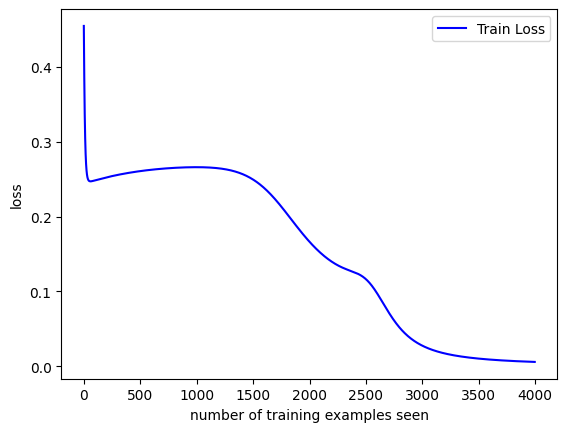

In [33]:
xor_network = NeuralNetwork(mse, mse_prime, 0.25)
xor_network.add(LinearLayer(2, 3))
xor_network.add(ActivationLayer(Sigmoid()))
xor_network.add(LinearLayer(3, 2))
xor_network.add(SoftmaxLayer(2))

training_data = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
labels = np.array([[[0,1]], [[1,0]], [[1,0]], [[0,1]]])

for i in range(1000):
    xor_network.train(training_data, labels, i)

out = xor_network.predict(training_data)
out = np.round(out)
print(out)

#Plot the loss
plt.plot(xor_network.train_counter, xor_network.train_loss, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
plt.show()


In [34]:
# We setup mini-batch with shuffling
def mini_batch(data, labels, batch_size):
    #Shuffle the data
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    #Split the data into batches
    batches = []
    for i in range(0, len(data), batch_size):
        batches.append((data[i:i+batch_size], labels[i:i+batch_size]))
    return batches

# We train the network to solve the MNIST dataset (without convolutional layers)

In [35]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))

    def backward(self, output_error):
        return np.reshape(output_error, self.input_shape)

mnist_network = NeuralNetwork(cel_loss, cel_prime, 0.1)
mnist_network.add(FlattenLayer((28,28)))
mnist_network.add(LinearLayer(28*28, 128))
mnist_network.add(ActivationLayer(ReLu()))
mnist_network.add(LinearLayer(128, 10))
mnist_network.add(SoftmaxLayer(10))

In [37]:
#Convert the labels to one-hot encoding
one_hot_labels = np.zeros((len(mnist_train_labels), 10))
for i in range(len(mnist_train_labels)):
    one_hot_labels[i][mnist_train_labels[i]] = 1

one_hot_labels_test = np.zeros((len(mnist_test_labels), 10))
for i in range(len(mnist_test_labels)):
    one_hot_labels_test[i][mnist_test_labels[i]] = 1

for i in range(20):
    batches = mini_batch(mnist_train_array[0:5000], one_hot_labels, 100)
    for j in range(len(batches)):
        mnist_network.train(batches[j][0], batches[j][1], i * len(batches) + j)


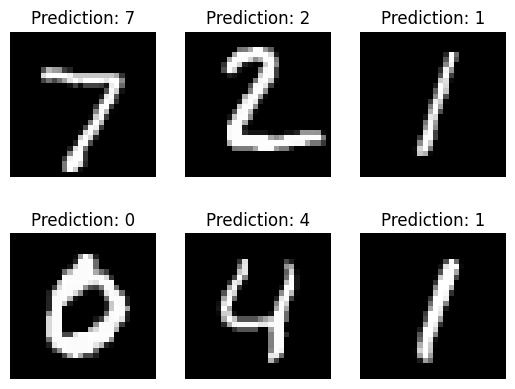

Correct predictions:  9445 / 10000
Accuracy:  0.9445


In [38]:
def show_some_results(model):
    out = model.predict(mnist_test_array)
    fig, axs = plt.subplots(2, 3)
    for i in range(2):
        for j in range(3):
            axs[i, j].imshow(mnist_test_array[i*3 + j].reshape(28, 28), cmap='gray')
            axs[i, j].set_title("Prediction: " + str(np.argmax(out[i*3 + j])))
            axs[i, j].axis('off')
    plt.show()

    correct = 0
    for i in range(len(out)):
        if np.argmax(out[i]) == mnist_test_labels[i]:
            correct += 1
    print("Correct predictions: ", correct, "/", len(out))
    print("Accuracy: ", correct / len(out))

show_some_results(mnist_network)

The Conv2D function is slow, so for now, I think avoiding it is better as it allows to use more data for training. I will try to optimize it later.

In [530]:
class Conv2D:

    def __init__(self, in_size, kern_size=5):
        self.in_size = in_size # (height is equal to width)
        self.kern_size = kern_size # (height is equal to width)

        self.out_size = in_size - kern_size + 1

        self.kernel = np.random.randn(kern_size, kern_size) / np.sqrt(kern_size * kern_size)
        self.bias = np.random.rand(1) - 0.5

        self.learning_rate = 0.01

    def forward(self, input):
        self.input = input
        self.output = np.zeros((self.out_size, self.out_size))

        # This is the logic without array operations
        for i in range(self.out_size):
            for j in range(self.out_size):
                self.output[i, j] = np.sum(self.input[i:i+self.kern_size, j:j+self.kern_size] * self.kernel) + self.bias
        return self.output

    def backward(self, output_error):
        #This is the logic without array operations
        in_err = np.zeros((self.in_size, self.in_size))
        kernel_err = np.zeros((self.kern_size, self.kern_size))
        bias_err = np.zeros(1)

        for i in range(self.out_size):
            for j in range(self.out_size):
                in_err[i:i+self.kern_size, j:j+self.kern_size] += output_error[i, j] * self.kernel
                kernel_err += output_error[i, j] * self.input[i:i+self.kern_size, j:j+self.kern_size]
                bias_err += output_error[i, j]

        self.kernel -= self.learning_rate * kernel_err
        self.bias -= self.learning_rate * bias_err
        return in_err

Testing out the forward prop of a convolutional layer is very easy, as convolutions are often used in image preprocessing. Here I use a gaussian kernel to apply gaussian blur on an image.

(24, 24)


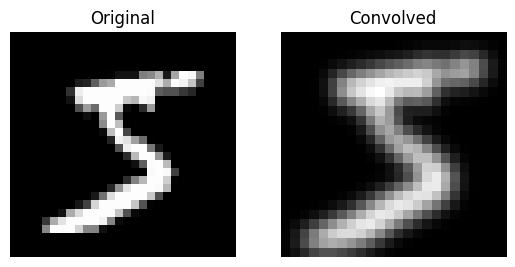

In [531]:
conv = Conv2D(28, 5)
conv.kernel = np.array([[1, 4, 6, 4, 1],
                        [4, 16, 24, 16, 4],
                        [6, 24, 36, 24, 6],
                        [4, 16, 24, 16, 4],
                        [1, 4, 6, 4, 1]]) / 256

out = conv.forward(mnist_train_array[0])
print(out.shape)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mnist_train_array[0].reshape(28, 28), cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(out, cmap='gray')
axs[1].set_title("Convolved")
axs[1].axis('off')
plt.show()

In [543]:
conv_network = NeuralNetwork(cel_loss, cel_prime, 0.01)
conv_network.add(Conv2D(28, 5))
conv_network.add(ActivationLayer(ReLu()))
conv_network.add(FlattenLayer((24,24)))
conv_network.add(LinearLayer(24*24, 200))
conv_network.add(ActivationLayer(ReLu()))
conv_network.add(LinearLayer(200, 10))
conv_network.add(SoftmaxLayer(10))

In [ ]:
for i in range(15):
    batches = mini_batch(mnist_train_array[0:2000], one_hot_labels, 100)
    for batch in batches:
        conv_network.train(batch[0], batch[1], i)

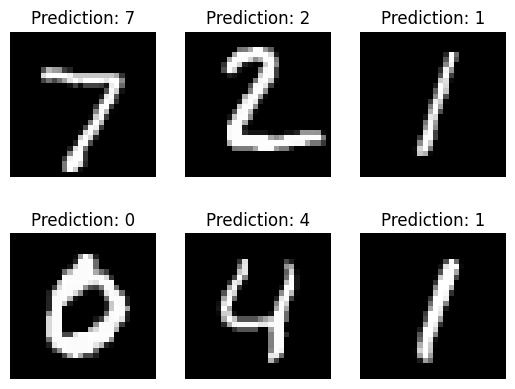

Correct predictions:  9260 / 10000
Accuracy:  0.926


In [542]:
show_some_results(conv_network)